# Import everything

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from tqdm.notebook import tqdm
import math

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz

# Load file paths of EEGs.

In [2]:
paths_raw = sorted(glob.glob('../tmseeg-matlab/dataset3/raw/*.mat'))
paths_raw_hjorth = sorted(glob.glob('../tmseeg-matlab/dataset3/raw-hjorth/*.mat'))
paths_clean = sorted(glob.glob('../tmseeg-matlab/dataset3/clean/*.mat'))
paths_clean_hjorth = sorted(glob.glob('../tmseeg-matlab/dataset3/clean-hjorth/*.mat'))
print("Raw: {}\nRaw Hjorth: {}\nClean: {}\nClean Hjorth: {}".format(len(paths_raw), len(paths_raw_hjorth), len(paths_clean), len(paths_clean_hjorth)))

Raw: 15
Raw Hjorth: 15
Clean: 15
Clean Hjorth: 15


# Read EEG files

In [3]:
def read_trials_from_raw(filename):
    x = loadmat(filename)
    x = x['EEGData']
    trials = []
    time = np.linspace(-1000, 0, len(x[0, :, 0]))
    for trial_num in range(x.shape[2]):
        trial = np.transpose(x[:, :, trial_num])
        trial = pd.DataFrame(data=trial, columns=['FP1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'IZ', 'OZ', 'POZ', 'PZ', 'CPZ', 'FPZ', 'FP2', 'AF8', 'AF4', 'AFZ', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCZ', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'M1', 'M2', 'NAS', 'LVEOG', 'RVEOG', 'LHEOG', 'RHEOG', 'NFPZ'])
        trial['time'] = time
        trials.append(trial)
    return trials

def read_trials_from_hjorth(filename):
    x = loadmat(filename)
    mat_trials = x['dat'][0][0][3][0]
    trials = []
    time = np.linspace(-1000, 0, len(mat_trials[0][0]))
    for mat_trial in mat_trials:
        trials.append(pd.DataFrame({'C3': mat_trial[0], 'C4': mat_trial[1], 'time': time}))
    return trials

# Power and phase calculation

In [4]:
def blackman_harris_filter(channel, time, cutoffs, fs, numtaps=801):
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def butter_bandpass_filter(data, lowcut, highcut, fs, btype='bandpass', order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    y = signal.lfilter(b, a, data)
    return y

def get_phase(channel, time, band, fs=256, filter_type='butter', start_time_ms=-750, stop_time_ms=-1):
    if filter_type=='butter':
        df_filtered = pd.DataFrame({'channel': butter_bandpass_filter(channel, band[0], band[1], fs), 'time': time})
    else:
        df_filtered = blackman_harris_filter(channel, time, [0.000001, band[0]], fs)
        df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, band[1], fs)    
    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > start_time_ms) * (df_filtered['time'] < stop_time_ms)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > start_time_ms) * (df_filtered['time'] < stop_time_ms)]['time'].values
    return df_phase

def get_power(channel, time, crop_start_millis=-150, method='pburg', filter_type='butter', fs=256):       
    # Crop.
    channel = channel[(time > crop_start_millis) * (time < -1)].values
    time = time[(time > crop_start_millis) * (time < -1)].values

    # Filer if gamma region.
    if filter_type == 'butter':
        resampled = butter_bandpass_filter(channel, 48, 52, fs, 'bandstop')
        resampled_time = time
    else:
        df_filtered = blackman_harris_filter(channel, time, [48, 52], fs, numtaps=101)
        resampled = df_filtered['channel']
        resampled_time = df_filtered['time']
    
    # PSD.
    try:
        if method == 'welch':
            # Welch method
            freq, power = signal.welch(resampled, fs, nfft=fs)
            freq_res = freq[1] - freq[0]
            df_power = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})
        elif method == 'fft':
            # FFT method
            power = np.abs(np.fft.fft(resampled, n=2*fs))
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})
        elif method == 'pburg':
            # Burgs method
            p = pburg(resampled, int(len(resampled)*.5), sampling=fs, NFFT=2000)
            power = p.psd
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})
    except:
        return 0

    df_power = df_power[df_power['freq'] < fs/2]
    return df_power

In [5]:
def process_trials(path_raw, path_raw_hjorth, path_clean, path_clean_hjorth):
    df_powers = []
    df_phases = []
    sub = path_raw.split('/')[-1].split('.')[0].split('_')[-1]
    trials_raw = read_trials_from_raw(path_raw)
    trials_raw_hjorth = read_trials_from_hjorth(path_raw_hjorth)
    trials_clean = read_trials_from_raw(path_clean)
    trials_clean_hjorth = read_trials_from_hjorth(path_clean_hjorth)
    for trial_num in range(len(trials_raw)):
        trial_raw = trials_raw[trial_num]
        trial_raw_hjorth = trials_raw_hjorth[trial_num]
        trial_clean = trials_clean[trial_num]
        trial_clean_hjorth = trials_clean_hjorth[trial_num]
        trial_clean_avg = trial_clean.copy()
        trial_clean_avg['C3'] = trial_clean_avg[['FC5', 'FC3', 'FC1', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1']].mean(axis=1)
        trial_raw_avg = trial_raw.copy()
        trial_raw_avg['C3'] = trial_raw_avg[['FC5', 'FC3', 'FC1', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1']].mean(axis=1)
        for eeg_type, artifact_removed, trial in zip(['Raw', 'Hjorth', 'Raw', 'Hjorth', 'Average', 'Average'], [False, False, True, True, True, False], [trial_raw, trial_raw_hjorth, trial_clean, trial_clean_hjorth, trial_clean_avg, trial_raw_avg]):
            for filter_name, filter_code in zip(['Butterworth', 'Blackmann-Harris'], ['butter', 'blackmann']):
                
                # PSD
                for time in [-150, -750]:
                    for method_name, method_code in zip(['Welch', 'FFT', 'Burg'], ['welch', 'fft', 'pburg']):
                        df_power = get_power(trial['C3'], trial['time'], crop_start_millis=time, method=method_code, filter_type=filter_code)
                        for band, fc1, fc2 in zip(['Theta', 'Mu', 'Beta', 'Gamma'], [3.5, 8, 13, 30], [8, 12, 30, 80]):
                            df_power2 = df_power[df_power['freq'] >= fc1]
                            df_power2 = df_power2[df_power2['freq'] < fc2]
                            power = df_power2['power'].mean(axis=0)
                            df_powers.append({
                                'sub': sub,
                                'trial': trial_num+1,
                                'EEG': eeg_type,
                                'ArtifactRemoved': artifact_removed,
                                'Filter': filter_name,
                                'Time': time,
                                'Method': method_name,
                                'Band': band,
                                'Power': power
                            })
                            
                # Phase
                for band, fc1, fc2 in zip(['Theta', 'Mu', 'Beta', 'Gamma'], [3.5, 8, 13, 30], [8, 12, 30, 80]):
                    df_phase = get_phase(trial['C3'], trial['time'], [fc1, fc1], fs=256, filter_type=filter_code)
                    phase = df_phase.iloc[-1]['phase'] + 180
                    df_phases.append({
                        'sub': sub,
                        'trial': trial_num+1,
                        'EEG': eeg_type,
                        'ArtifactRemoved': artifact_removed,
                        'Filter': filter_name,
                        'Band': band,
                        'Phase': phase
                    })
    return (df_powers, df_phases)

In [6]:
paths = [list(a) for a in zip(paths_raw, paths_raw_hjorth, paths_clean, paths_clean_hjorth)]
a

In [9]:
df_powers = pd.DataFrame()
df_phases = pd.DataFrame()
for df_power, df_phase in tqdm(results):
    df_powers = pd.concat([df_powers, pd.DataFrame(df_power)])
    df_phases = pd.concat([df_powers, pd.DataFrame(df_phase)])

/Users/alam/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [16]:
df_powers.to_csv('166-d3-powers.csv')

In [30]:
df_phases.to_csv('166-d3-phases.csv')

In [20]:
df_powers.head()

,sub,trial,EEG,ArtifactRemoved,Filter,Time,Method,Band,Power
0,S1,1,Raw,False,Butterworth,-150,Welch,Theta,3.543205
1,S1,1,Raw,False,Butterworth,-150,Welch,Mu,4.493498
2,S1,1,Raw,False,Butterworth,-150,Welch,Beta,-4.442415
3,S1,1,Raw,False,Butterworth,-150,Welch,Gamma,-12.373460
4,S1,1,Raw,False,Butterworth,-150,FFT,Theta,20.413904


# Power - box plot

In [3]:
df_powers = pd.read_csv('166-d3-powers.csv')
df_phases = pd.read_csv('166-d3-phases.csv')

In [4]:
def_values_power = {
    'ArtifactRemoved': True,
    'EEG': 'Raw',
    'Filter': 'Butterworth',
    'Time': -150,
    'Method': 'Welch'
}
hue_order = {
    'ArtifactRemoved': [True, False],
    'EEG': ['Raw', 'Hjorth', 'Average'],
    'Filter': ['Butterworth', 'Blackmann-Harris'],
    'Time': [-150, -750],
    'Method': ['FFT', 'Welch', 'Burg']
}

def_values_phase = {
    'ArtifactRemoved': True,
    'EEG': 'Raw',
    'Filter': 'Butterworth'
}

--------------
ArtifactRemoved
--------------
Performing EEG = Raw for constant ArtifactRemoved, shape = (48768, 9)
Performing Filter = Butterworth for constant ArtifactRemoved, shape = (24384, 9)
Performing Time = -150 for constant ArtifactRemoved, shape = (12192, 9)
Performing Method = Welch for constant ArtifactRemoved, shape = (4064, 9)
--------------
EEG
--------------
Performing ArtifactRemoved = True for constant EEG, shape = (73152, 9)
Performing Filter = Butterworth for constant EEG, shape = (36576, 9)
Performing Time = -150 for constant EEG, shape = (18288, 9)
Performing Method = Welch for constant EEG, shape = (6096, 9)
--------------
Filter
--------------
Performing ArtifactRemoved = True for constant Filter, shape = (73152, 9)
Performing EEG = Raw for constant Filter, shape = (24384, 9)
Performing Time = -150 for constant Filter, shape = (12192, 9)
Performing Method = Welch for constant Filter, shape = (4064, 9)
--------------
Time
--------------
Performing ArtifactRemoved

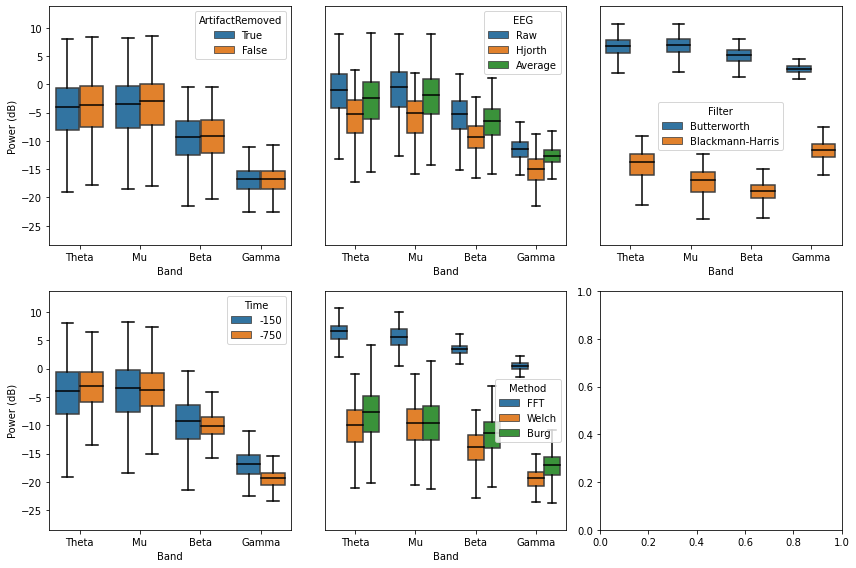

In [28]:
df_power2 = df_powers[df_powers['sub'] == 'S10']

# with plt.style.context(['science-raquib2']):
f, axs = plt.subplots(2,3,figsize=(12,8))
i = 0
j = 0
for variable in tqdm(list(def_values_power.keys())):    
    df_power3 = df_power2
    print('--------------')
    print(variable)
    print('--------------')
    for key, value in def_values_power.items():
        if key != variable:
            df_power3 = df_power3[df_power3[key] == value]
            print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

    sns.boxplot(x="Band", y="Power", hue=variable, data=df_power3, ax=axs[i, j], fliersize=0, hue_order=hue_order[variable])
    # axs[i, j].set_ylim([-25,30])
    plt.setp(axs[i, j].lines, color='k')
    # axs[i, j].get_legend().remove()
    if j == 0:
        axs[i, j].set_ylabel('Power (dB)')
    else:
        axs[i, j].set_ylabel('')
        axs[i, j].get_yaxis().set_ticks([])
    j = j + 1
    if j > 2:
        j = 0
        i = i + 1

plt.tight_layout()

# Phase - histogram

ArtifactRemoved, Band: Theta, Options: [False  True]



/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret

ZeroDivisionError: 0.0 cannot be raised to a negative power

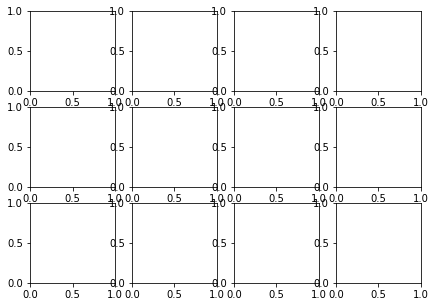

In [5]:
df_phase2 = df_phases[df_phases['sub'] == 'S10']
colors = ['#EF5350', '#43A047', '#039BE5']
f, axs = plt.subplots(3, 4, figsize=(7,5))
i = 0
j = 0
color_ind = 0
for variable in tqdm(list(def_values_phase.keys())):
    df_phase3 = df_phase2.copy()
    for key, value in def_values_phase.items():
            if key != variable:
                df_phase3 = df_phase3[df_phase3[key] == value]
    for band in ['Theta', 'Mu', 'Beta', 'Gamma']:
        print('{}, Band: {}, Options: {}'.format(variable, band, df_phase3[variable].unique()))
        for option in df_phase3[variable].unique():
            df_phase4 = df_phase3[df_phase3['Band'] == band]
            df_phase4 = df_phase4[df_phase4[variable] == option]
            sns.distplot(df_phase4['Phase'], hist=False, color=colors[color_ind], kde_kws={"shade": True}, ax=axs[i, j])
            color_ind = color_ind + 1
            if i == 2:
                axs[i, j].set_xlabel('Phase (degrees)')
            else:
                axs[i, j].set_xlabel('')
            axs[i, j].set_xlim([0, 360])
            axs[i, j].set_ylim([0, 0.007])
            axs[i, j].set_xticks([0, 90, 180, 270, 360])
        if i == 0:
            axs[i, j].set_title(band)
        if j == 0:
            axs[i, j].set_ylabel('Density')
        else:
            axs[i, j].get_yaxis().set_visible(False)
        j = j + 1
        if j > 3:
            j = 0
        color_ind = 0
    i = i + 1

plt.tight_layout()

# Trial - power

In [8]:
df_power3.columns.values

array(['Unnamed: 0', 'sub', 'trial', 'EEG', 'ArtifactRemoved', 'Filter',
       'Time', 'Method', 'Band', 'Power'], dtype=object)

--------------
ArtifactRemoved
--------------
Performing EEG = Raw for constant ArtifactRemoved, shape = (12192, 10)
Performing Filter = Butterworth for constant ArtifactRemoved, shape = (6096, 10)
Performing Time = -150 for constant ArtifactRemoved, shape = (3048, 10)
Performing Method = Welch for constant ArtifactRemoved, shape = (1016, 10)
--------------
EEG
--------------
Performing ArtifactRemoved = True for constant EEG, shape = (18288, 10)
Performing Filter = Butterworth for constant EEG, shape = (9144, 10)
Performing Time = -150 for constant EEG, shape = (4572, 10)
Performing Method = Welch for constant EEG, shape = (1524, 10)
--------------
Filter
--------------
Performing ArtifactRemoved = True for constant Filter, shape = (18288, 10)
Performing EEG = Raw for constant Filter, shape = (6096, 10)
Performing Time = -150 for constant Filter, shape = (3048, 10)
Performing Method = Welch for constant Filter, shape = (1016, 10)
--------------
Time
--------------
Performing ArtifactR

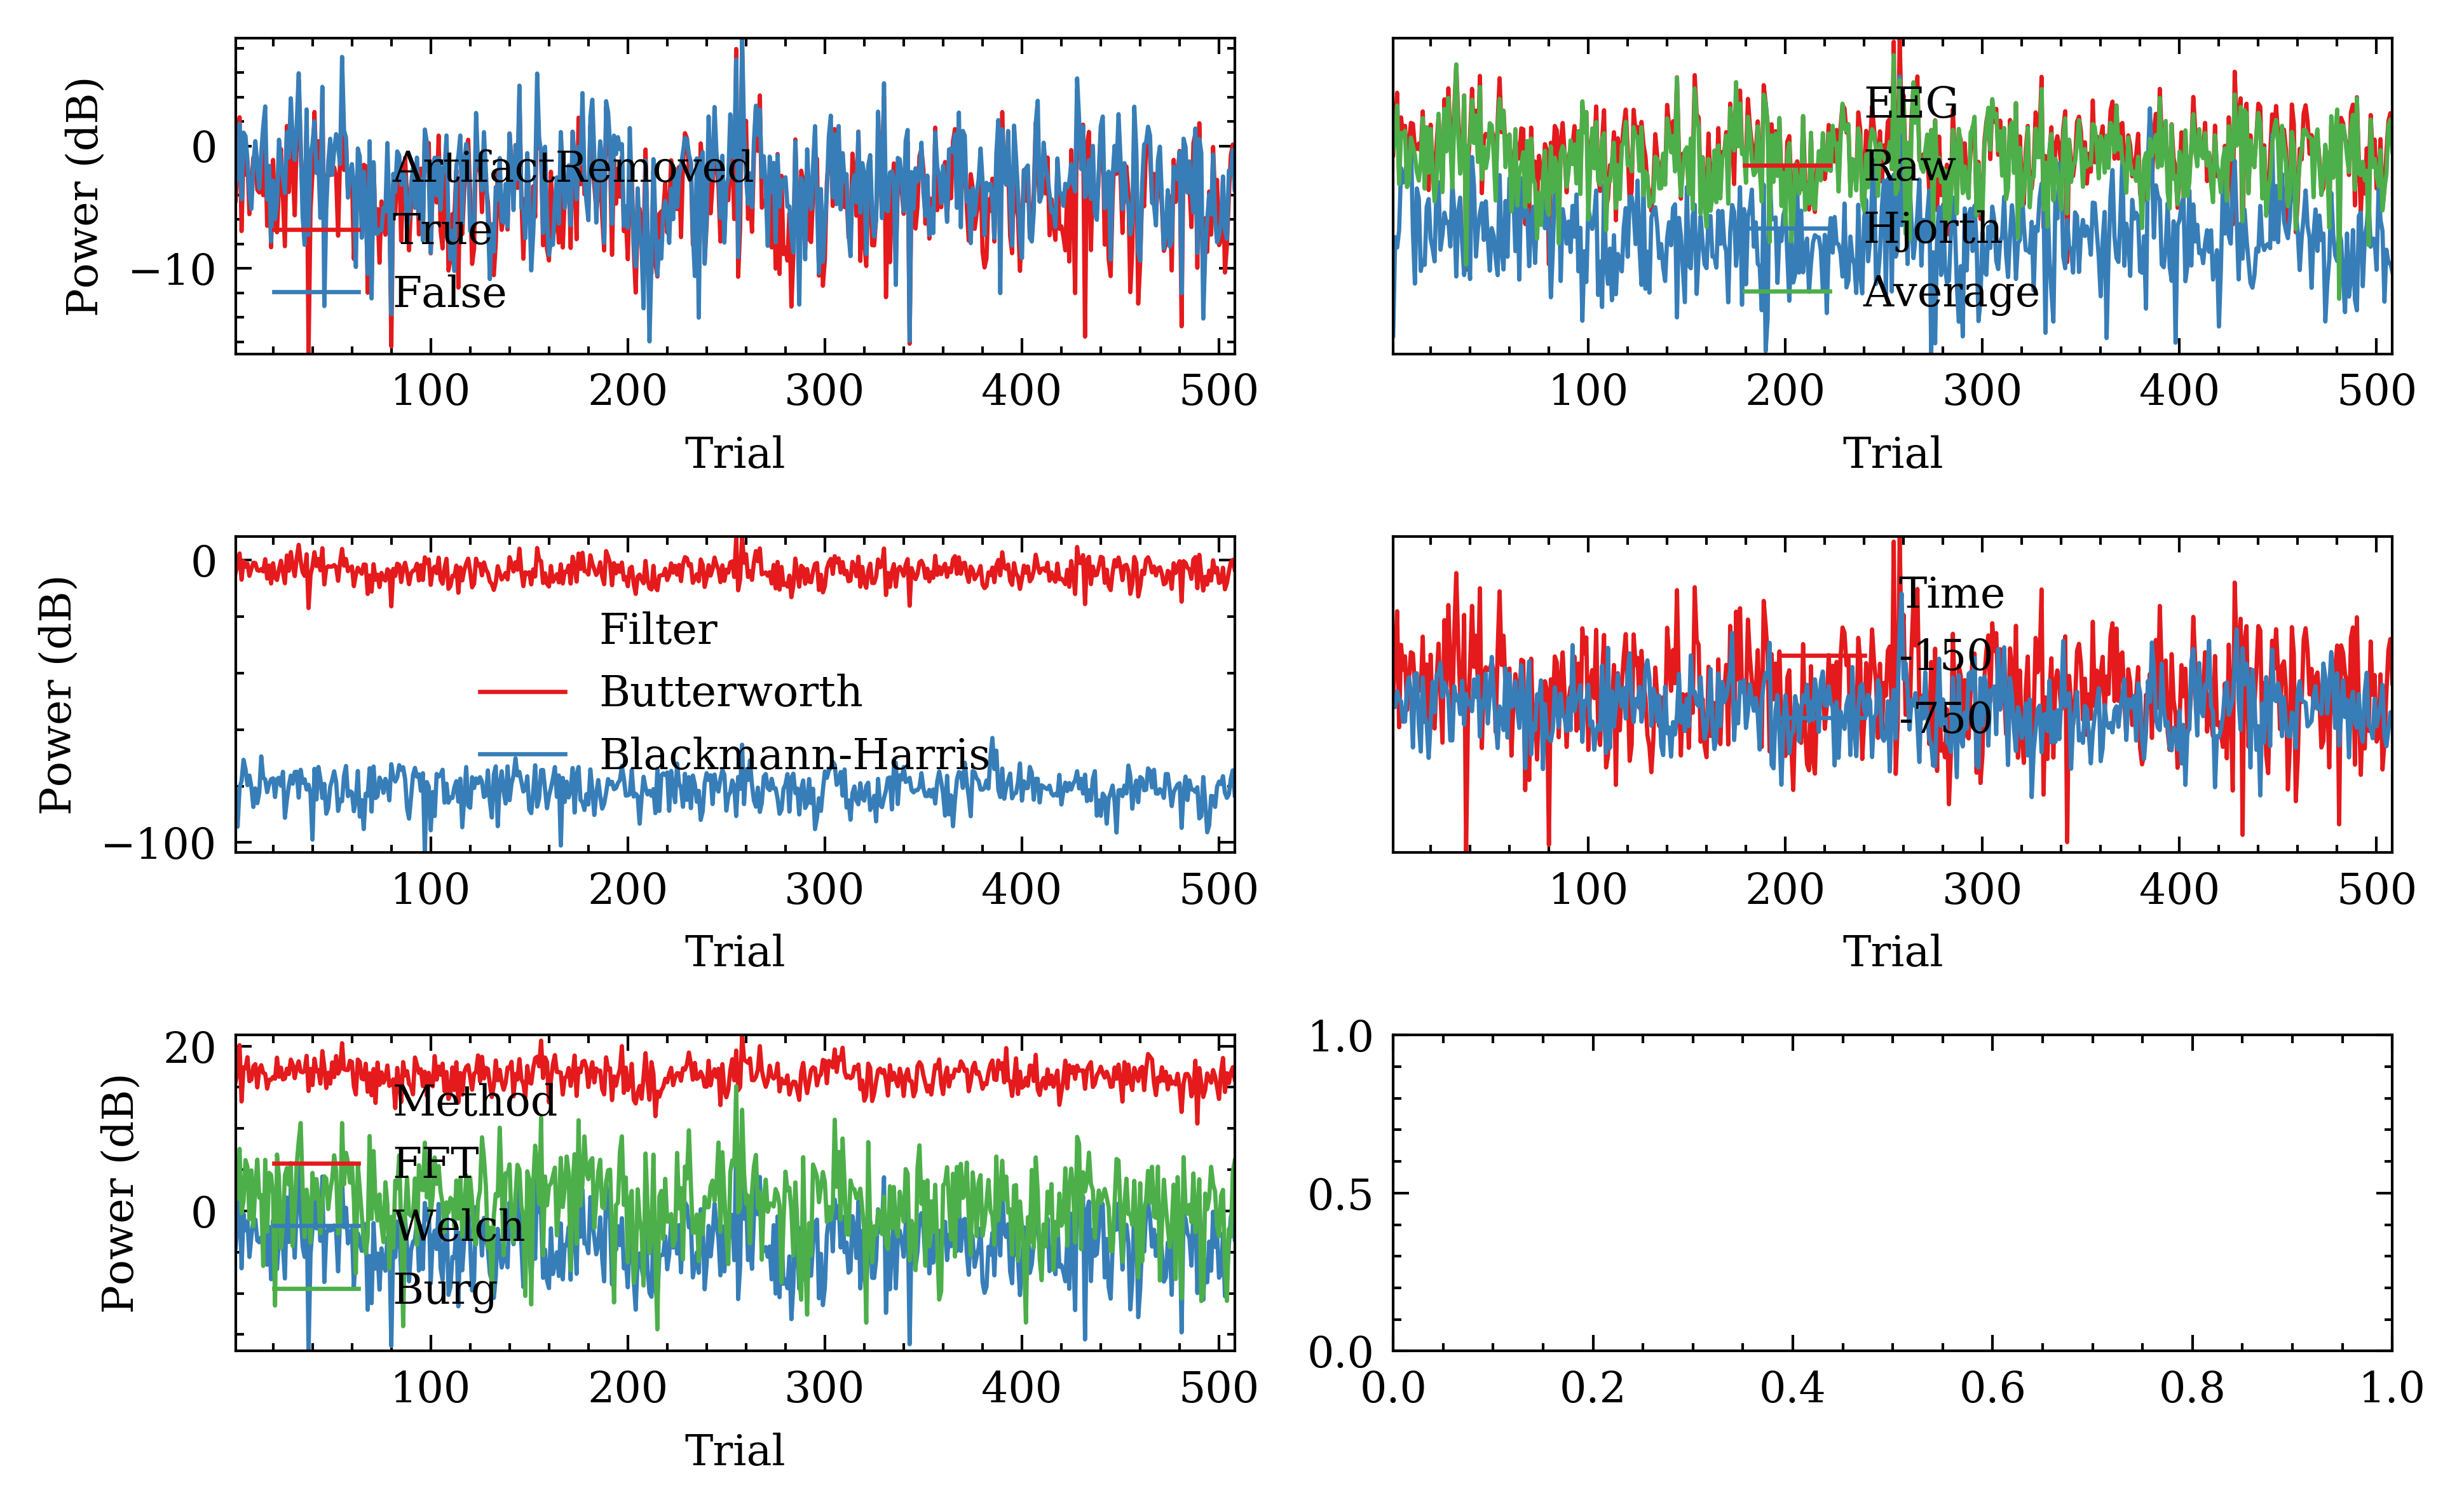

In [11]:
df_power2 = df_powers[df_powers['sub'] == df_powers['sub'].unique()[5]]
df_power2 = df_power2[df_power2['Band'] == 'Beta']
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(3, 2, figsize=(6.5,4))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        df_power3 = df_power3[['trial', 'Power', variable]]
        sns.lineplot(x="trial", y="Power", hue=variable, data=df_power3, ax=axs[i, j], hue_order=hue_order[variable], palette=sns.color_palette("Set1", df_power3[variable].nunique()))
        # axs[i, j].set_ylim([-25,35])
        # plt.setp(axs[i, j].lines, color='k')
        # axs[i, j].get_legend().remove()
        axs[i,j].set_xlabel('Trial')
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1

    plt.tight_layout()